# brmspy - Variational Inference

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/18BgqZrbnzWa3YRrfbnU_54JfwK7FXDvC)



In [1]:

import os
import sys

import sys, os # for running from repo
sys.path.insert(0, os.path.abspath(".."))

try: from brmspy import brms
except ImportError:
    %pip install -q brmspy
    from brmspy import brms

import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

[brmspy][_call_with_frames_removed] Running autoload!
[brmspy][_autoload] Activating runtime /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0
[brmspy][_autoload] lib paths are ['/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/library', '/Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/Rlib']
[brmspy][_autoload] Setting cmdstan path to /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/cmdstan


In [2]:
with brms.manage() as ctx:
    ctx.install_brms(use_prebuilt=True)

[brmspy][install_brms] Activating runtime /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0
[brmspy][install_brms] lib paths are ['/Users/sebastian/.brmspy/environment/default/Rlib', '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/library', '/Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/Rlib']
[brmspy][install_brms] Setting cmdstan path to /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/cmdstan


In [3]:
df = brms.get_brms_data("epilepsy")

In [4]:
model = brms.brm(
    formula="count ~ zAge + zBase * Trt + (1|patient)",
    family="negbinomial", 
    data=df,
    
    # 1. ALGORITHM
    algorithm="meanfield",
    
    # 2. OPTIMIZATION LOOP
    iter=30000,
    eta=0.1,
    adapt_engaged=True,
    
    # 3. GRADIENT ESTIMATION (Reducing Noise)
    grad_samples=5,
    elbo_samples=100,
    
    # 4. CONVERGENCE CRITERIA
    eval_elbo=200,
    tol_rel_obj=0.0001,
    
    seed=42,

    refresh=0, silent=2
)

[brmspy][worker_main] Fitting model with brms (backend: cmdstanr)...
------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 6.5e-05 seconds 
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   200         -652.394             1.000            1.000 
   400         -652.970             0.5

Computed from 1000 posterior samples and 236 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -623.39    17.86
p_loo       45.52        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.67]   (good)      227   96.2%
   (0.67, 1]   (bad)         7    3.0%
   (1, Inf)   (very bad)    2    0.8%



/Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


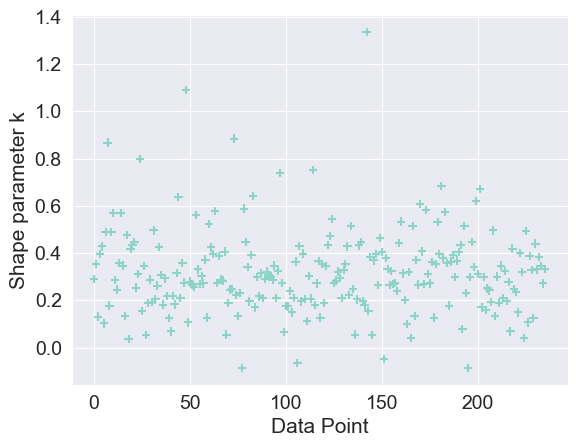

In [5]:
loo_res = az.loo(model.idata, pointwise=True)
print(loo_res)

# Visualize the k-hats
az.plot_khat(loo_res)
plt.show()

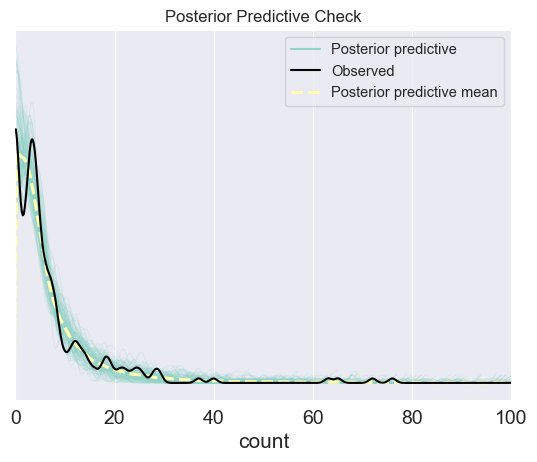

In [6]:
az.plot_ppc(model.idata, num_pp_samples=100)
plt.title("Posterior Predictive Check")
plt.xlim(0, 100)
plt.show()

In [7]:
pred = brms.posterior_predict(model)

In [8]:
summary = brms.summary(model)
summary

[brmspy][iterate_robject_to_dataclass][WARNING] Type of param 'iter' <class 'int'> does not match expected '<class 'float'>'


 Family: negbinomial 
  Links: mu = log 
Formula: count ~ zAge + zBase * Trt + (1 | patient) 
   Data: structure(list(Age = c(31, 30, 25, 36, 22, 29, 31, (Number of observations: 236) 
  Draws: 1 chains, each with iter = 1000; warmup = 0; thin = 1;
         total post-warmup draws = 1000

Multilevel Hyperparameters:
~patient (Number of levels: 59) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.49      0.04     0.43     0.57 1.00      882      981

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     2.04      0.12     1.81     2.29 1.00     1114     1022
zAge          0.10      0.04     0.02     0.18 1.00     1164      979
zBase         0.65      0.03     0.58     0.71 1.00      926      908
Trt          -0.25      0.07    -0.40    -0.10 1.00     1065      980
zBase:Trt     0.04      0.02     0.00     0.08 1.00      948      940

Further Distributional Parameters:
      Estimate Est.